# Mini-FaceNet Project: MLP

In [34]:
# Import requred libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [35]:
# Todo 1: Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
# Todo 2: Define the transformations
# transform = transforms.Compose([
#     transforms.Resize((96, 96)),  # Resize to 96x96
#     transforms.ToTensor(),        # Convert to Tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
# ])


In [37]:
# Todo 1: Define the transformations

augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop((96, 96), scale=(0.5, 1.0), ratio=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

basic_transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [38]:
# Load the dataset
dataset = torchvision.datasets.ImageFolder(root='faces/', transform=None)

In [39]:
# Todo 3: Split the dataset into train, validation and test sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [40]:
# Todo 3: Add transformations
train_dataset.dataset.transform = augmentation_transforms
valid_dataset.dataset.transform = basic_transforms
test_dataset.dataset.transform = basic_transforms

In [41]:
# Todo 4: Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [42]:
# Todo 5: Define the model
# MLP Model
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(96*96*3, 100)  # 3 for RGB channels
#         self.fc2 = nn.Linear(100, 10)
#         self.fc3 = nn.Linear(10, 2)  # 2 output classes

#     def forward(self, x):
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model = MLP().to(device)

In [43]:
# Todo 4: Define the model

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 3 input channels (RGB), 32 output channels
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)  # Max pooling
#         self.fc1 = nn.Linear(64 * 24 * 24, 128)  # Fully connected layers
#         self.fc2 = nn.Linear(128, 2)  # 2 output classes

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 24 * 24)  # Flatten the tensor for the fully connected layer
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# model = CNN().to(device)

In [44]:
import torchvision.models as models

# Load a pretrained model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

# Set only the last layer to be trainable
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)


In [45]:
# Define losses and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# Todo 6: Define the training/val loop
# Training loop
num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch [1/1], Train Loss: 0.1333, Validation Loss: 0.0570


Accuracy of the network on test images: 98.46553352219074 %


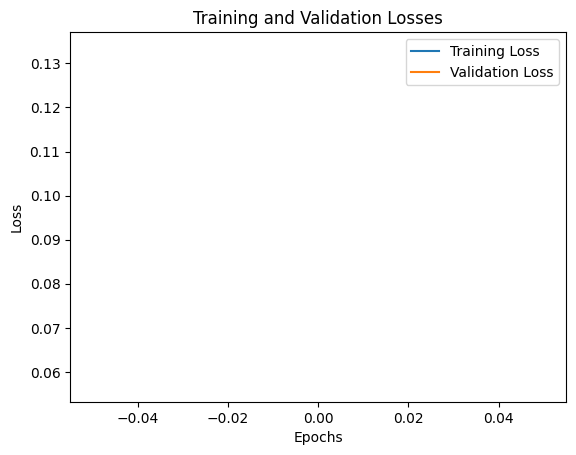

In [47]:
# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total} %')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
# Convert to evaluation mode
model.eval()
model.to("cpu")
model_scripted = torch.jit.script(model) 
model_scripted.save('minifacenet_resnet.pt') # Save

